In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.anomaly/.prcp/dods'
ds = xr.open_dataset(url,decode_times=False,chunks=-1).load()
ds['T'] = pd.date_range('1979-01',periods = len(ds['T']),freq='MS').shift(15, freq='D') 
ds=ds.sel(T=slice('2020-06','2020-08'),Y=slice(-10,70))
dsanomcutmean=ds.mean('T')

In [3]:
url='http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/dods'
ds2 = xr.open_dataset(url,decode_times=False).sortby('Y').load()
ds2=ds2.phi.sel(P=700, method='nearest')
ds2=ds2.drop(['P'])
ds2['T'] = pd.date_range('1949-01',periods = len(ds2['T']),freq='MS').shift(15, freq='D') 
ds2=ds2.sel(T=slice('1979-01','2021-02'),Y=slice(-10,70))
ds2anom=ds2.groupby('T.month') - ds2.groupby('T.month').mean()
ds2anomcut=ds2anom.sel(T=slice('2020-06','2020-08'))
ds2anomcutmean=ds2anomcut.mean('T')

In [4]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
 
cmap_data = [(0, rgb2hex(130, 90, 80)), \
             (0.0625, rgb2hex(150, 110, 100)), \
             (0.125, rgb2hex(170, 130, 120)), \
             (0.1875, rgb2hex(180, 140, 130)), \
             (0.25, rgb2hex(190, 150, 140)), \
             (0.3125, rgb2hex(200, 160, 150)), \
             (0.375, rgb2hex(220, 185, 175)), \
             (0.4375, rgb2hex(240, 215, 210)), \
             (0.49, rgb2hex(255, 255, 255)), \
             (0.51, rgb2hex(255, 255, 255)), \
             (0.525, rgb2hex(210, 255, 215)), \
             (0.5625, rgb2hex(150, 230, 155)), \
             (0.625, rgb2hex(110, 210, 115)), \
             (0.6875, rgb2hex(45, 180, 50)), \
             (0.75, rgb2hex(20, 170, 25)), \
             (0.8125, rgb2hex(10, 150, 15)), \
             (0.875, rgb2hex(0, 130, 5)), \
             (1,rgb2hex(0, 110, 4))]
cmap = colors.LinearSegmentedColormap.from_list('prcp_anomaly', cmap_data)
plt.register_cmap('prcp_anomaly', cmap)

In [5]:
lon_min = 30; lon_max = 390; center_lon = (lon_min + lon_max)/2
ds_cut = dsanomcutmean.prcp.copy()
ds2_cut = ds2anomcutmean.copy()
ds_cut.coords['X'] = (ds_cut.coords['X'] - lon_min) % 360 + lon_min; ds_cut = ds_cut.sortby('X')
ds2_cut.coords['X'] = (ds2_cut.coords['X'] - lon_min) % 360 + lon_min; ds2_cut = ds2_cut.sortby('X')

0

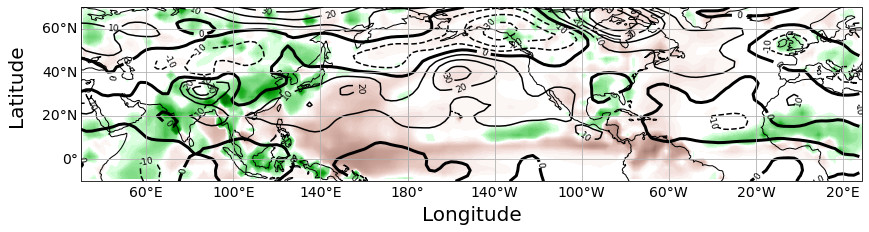

In [26]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=center_lon))
ds_cut.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10,vmax=10, levels=101, cmap='prcp_anomaly', add_colorbar=False)
CS = ds2_cut.plot.contour(ax=ax, colors='k', transform=ccrs.PlateCarree(), vmin=-50,vmax=50, levels=11)
CS.collections[5].set_linewidth(3)
ax.clabel(CS, inline=1, fontsize=9, fmt='%1.0f')
ax.add_feature(cfeature.COASTLINE);

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor', size=20, weight='bold',
#        transform=ax.transAxes)
#ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center', size=20, weight='bold',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes)

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', size=20, 
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center', size=20, 
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
    
    
gl = ax.gridlines(draw_labels=True, alpha=1.0, xlocs=np.arange(-180,181,40), ylocs=np.arange(0,70,20), linestyle='-')
gl.top_labels = False
gl.right_labels = False
#gl.xlabel_style = {'size': 15, 'weight': 'bold'}
#gl.ylabel_style = {'size': 15, 'weight': 'bold'}
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.savefig('precipcontourplot.eps')
os.system(f'/usr/bin/ps2eps -B -C < precipcontourplot.eps > precipcontourplotcut.eps')

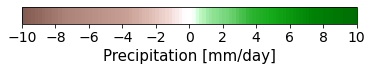

In [27]:
ds_cutclip=np.clip(ds_cut,-10,10)
cb = ds_cutclip.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10.,vmax=10., levels=101, cmap='prcp_anomaly', add_colorbar=False)
plt.gca().set_visible(False)
a = np.arange(-10,10.1,2)
cbar = plt.colorbar(cb, extendrect = True, orientation='horizontal', ticks=a)
cbar.ax.tick_params(labelsize=14)
#cbar.set_label(label='Precipitation [mm/day]', weight='bold', size=15)
cbar.set_label(label='Precipitation [mm/day]', size=15)
plt.savefig('colorplot.eps')
os.system(f'/usr/bin/ps2eps -B -C < colorplot.eps > colorplotcut.eps');